In [2]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, execute
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [3]:
#We used the W state implementation from W state in reference 6
def control_rotation (qcir,cQbit,tQbit,theta):
    """ Create an intermediate controlled rotation using only unitary gate and controlled-NOT

    Args:
    qcir: QuantumCircuit instance to apply the controlled rotation to.
    cQbit: control qubit.
    tQbit: target qubit.
    theta: rotation angle.

    Returns:
    A modified version of the QuantumCircuit instance with control rotation applied.

    """
    theta_dash = math.asin(math.cos(math.radians(theta/2)))
    qcir.u(theta_dash,0,0,tQbit)
    qcir.cx(cQbit,tQbit)
    qcir.u(-theta_dash,0,0,tQbit)
    return qcir


def wn (qcir,qbits):
    """ Create the W-state using the control-rotation function.

    Args:
    qcir: QuantumCircuit instance used to construct the W-state.
    qbits: the qubits used to construct the W-state.

    Returns:
    A modified version of the QuantumCircuit instance with the W-state construction gates.

    """
    for i in range(len(qbits)):
        if i == 0:
            qcir.x(qbits[0])
            qcir.barrier()
        else:
            p = 1/(len(qbits)-(i-1))
            theta = math.degrees(math.acos(math.sqrt(p)))
            theta = 2* theta
            qcir = control_rotation(qcir,qbits[i-1],qbits[i],theta)
            qcir.cx(qbits[i],qbits[i-1])
            qcir.barrier()
    return qcir,qbits

In [4]:
def edge_counter(qc,qubits,anc,flag_qubit,k):
    bin_k = bin(k)[2:][::-1]
    l = []
    for i in range(len(bin_k)):
        if int(bin_k[i]) == 1:
            l.append(qubits[i])
    qc.mct(l,flag_qubit,[anc])


def oracle(n_nodes, edges, qc, nodes_qubits, edge_anc, ancilla, neg_base):
    k = 3 #k is the number of edges, in case of a triangle, it's 3
    #1- edge counter
    #forward circuit
    qc.barrier()
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    for i in range(1,len(edges)):
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
    #----------------------------------------------------------------------------------------------------------
     #Edges check Qubit
    edg_k = int((k/2)*(k-1))
    edge_counter(qc,edge_anc,ancilla[0],neg_base[0],edg_k)
    #----------------------------------------------------------------------------------------------------------

    #4- Reverse edge count
    for i in range(len(edges)-1,0,-1):
        qc.ccx(nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0])
        qc.mct([nodes_qubits[edges[i][0] ],nodes_qubits[edges[i][1] ],edge_anc[0] ], edge_anc[1], [ancilla[0] ])
    qc.ccx(nodes_qubits[edges[0][0] ],nodes_qubits[edges[0][1] ],edge_anc[0])
    qc.barrier()

In [5]:
def cnz(qc, num_control, node, anc):
    """Construct a multi-controlled Z gate

    Args:
    num_control :  number of control qubits of cnz gate
    node :             node qubits
    anc :               ancillaly qubits
    """
    if num_control>2:
        qc.ccx(node[0], node[1], anc[0])
        for i in range(num_control-2):
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.cz(anc[num_control-2], node[num_control])
        for i in range(num_control-2)[::-1]:
            qc.ccx(node[i+2], anc[i], anc[i+1])
        qc.ccx(node[0], node[1], anc[0])
    if num_control==2:
        qc.h(node[2])
        qc.ccx(node[0], node[1], node[2])
        qc.h(node[2])
    if num_control==1:
        qc.cz(node[0], node[1])

In [6]:
def grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep):
    qc.append(inv_stat_prep,qargs=nodes_qubits)
    qc.x(nodes_qubits)
    #====================================================
        #3 control qubits Z gate
    cnz(qc,len(nodes_qubits)-1,nodes_qubits[::-1],ancilla)
    #====================================================
    qc.x(nodes_qubits)
    qc.append(stat_prep,qargs=nodes_qubits)

In [7]:
# Grover algo function
def grover(n_nodes,stat_prep,inv_stat_prep, edges):
    #N = 2**n_nodes  # for optimal iterations count if the state prep is done using only H gates.
    N = math.comb(n_nodes, 3) #Since we are using W-state to perform initial preparation.
    nodes_qubits = QuantumRegister(n_nodes, name='nodes')
    edge_anc = QuantumRegister(2, name='edge_anc')
    ancilla = QuantumRegister(n_nodes-2, name = 'cccx_diff_anc')
    neg_base = QuantumRegister(1, name='check_qubits')
    class_bits = ClassicalRegister(n_nodes, name='class_reg')
    tri_flag = ClassicalRegister(3, name='tri_flag')
    qc = QuantumCircuit(nodes_qubits, edge_anc, ancilla, neg_base, class_bits, tri_flag)
    # Initialize qunatum flag qubits in |-> state
    qc.x(neg_base[0])
    qc.h(neg_base[0])
    # Initializing i/p qubits in superposition
    qc.append(stat_prep,qargs=nodes_qubits)
    qc.barrier()
    # Calculate iteration count
    iterations = math.floor(math.pi/4*math.sqrt(N))
    # Calculate iteration count
    for i in np.arange(iterations):
        qc.barrier()
        oracle(n_nodes, edges, qc, nodes_qubits, edge_anc,  ancilla, neg_base)
        qc.barrier()
        grover_diff(qc, nodes_qubits,edge_anc,ancilla,stat_prep,inv_stat_prep)
    qc.measure(nodes_qubits,class_bits)
    return qc

In [8]:
def draw_graph(n_nodes, edges, found_str=None):
    node_angles = 2*np.pi*np.arange(n_nodes)/n_nodes
    node_coords = np.array([np.cos(node_angles), np.sin(node_angles)]).T

    for coords in node_coords:
        plt.plot(*coords, marker="o", color="black")
    for edge in edges:
        plt.plot(*node_coords[np.array(edge)].T, color="black")

    if found_str is not None:
        for coords, is_found in zip(node_coords, found_str):
            if is_found == "1":
                plt.plot(*coords, marker=".", color="white")

    plt.axis("off")
    plt.show()

In [9]:
def grover_triangle_finder(n_nodes, edges):
    sub_qbits = QuantumRegister(n_nodes)
    sub_cir = QuantumCircuit(sub_qbits, name="state_prep")
    sub_cir, sub_qbits = wn(sub_cir, sub_qbits)
    sub_cir.x(sub_qbits)
    stat_prep = sub_cir.to_instruction()
    inv_stat_prep = sub_cir.inverse().to_instruction()

    return grover(n_nodes,stat_prep,inv_stat_prep, edges)

def simulate(qc, shots=5000):
    # Simulate and plot results
    qasm_simulator = Aer.get_backend('qasm_simulator')
    #transpiled_qc = transpile(qc, qasm_simulator)
    # Execute circuit and show results
    ex = execute(qc, qasm_simulator, shots = shots)
    res = ex.result().get_counts(qc)
    return res


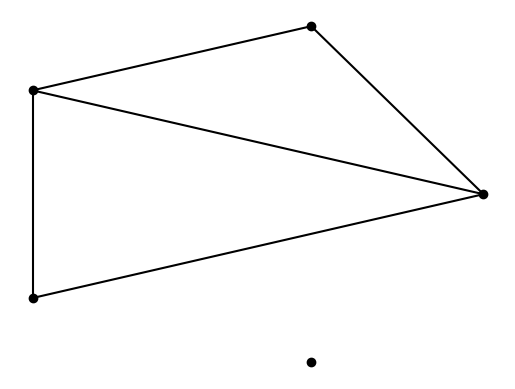

In [21]:
#Edges list
edges =[(0, 2), (0, 1), (1, 2), (2, 3),  (0, 3)]
#Number of nodes
n_nodes = 5

draw_graph(n_nodes, edges)

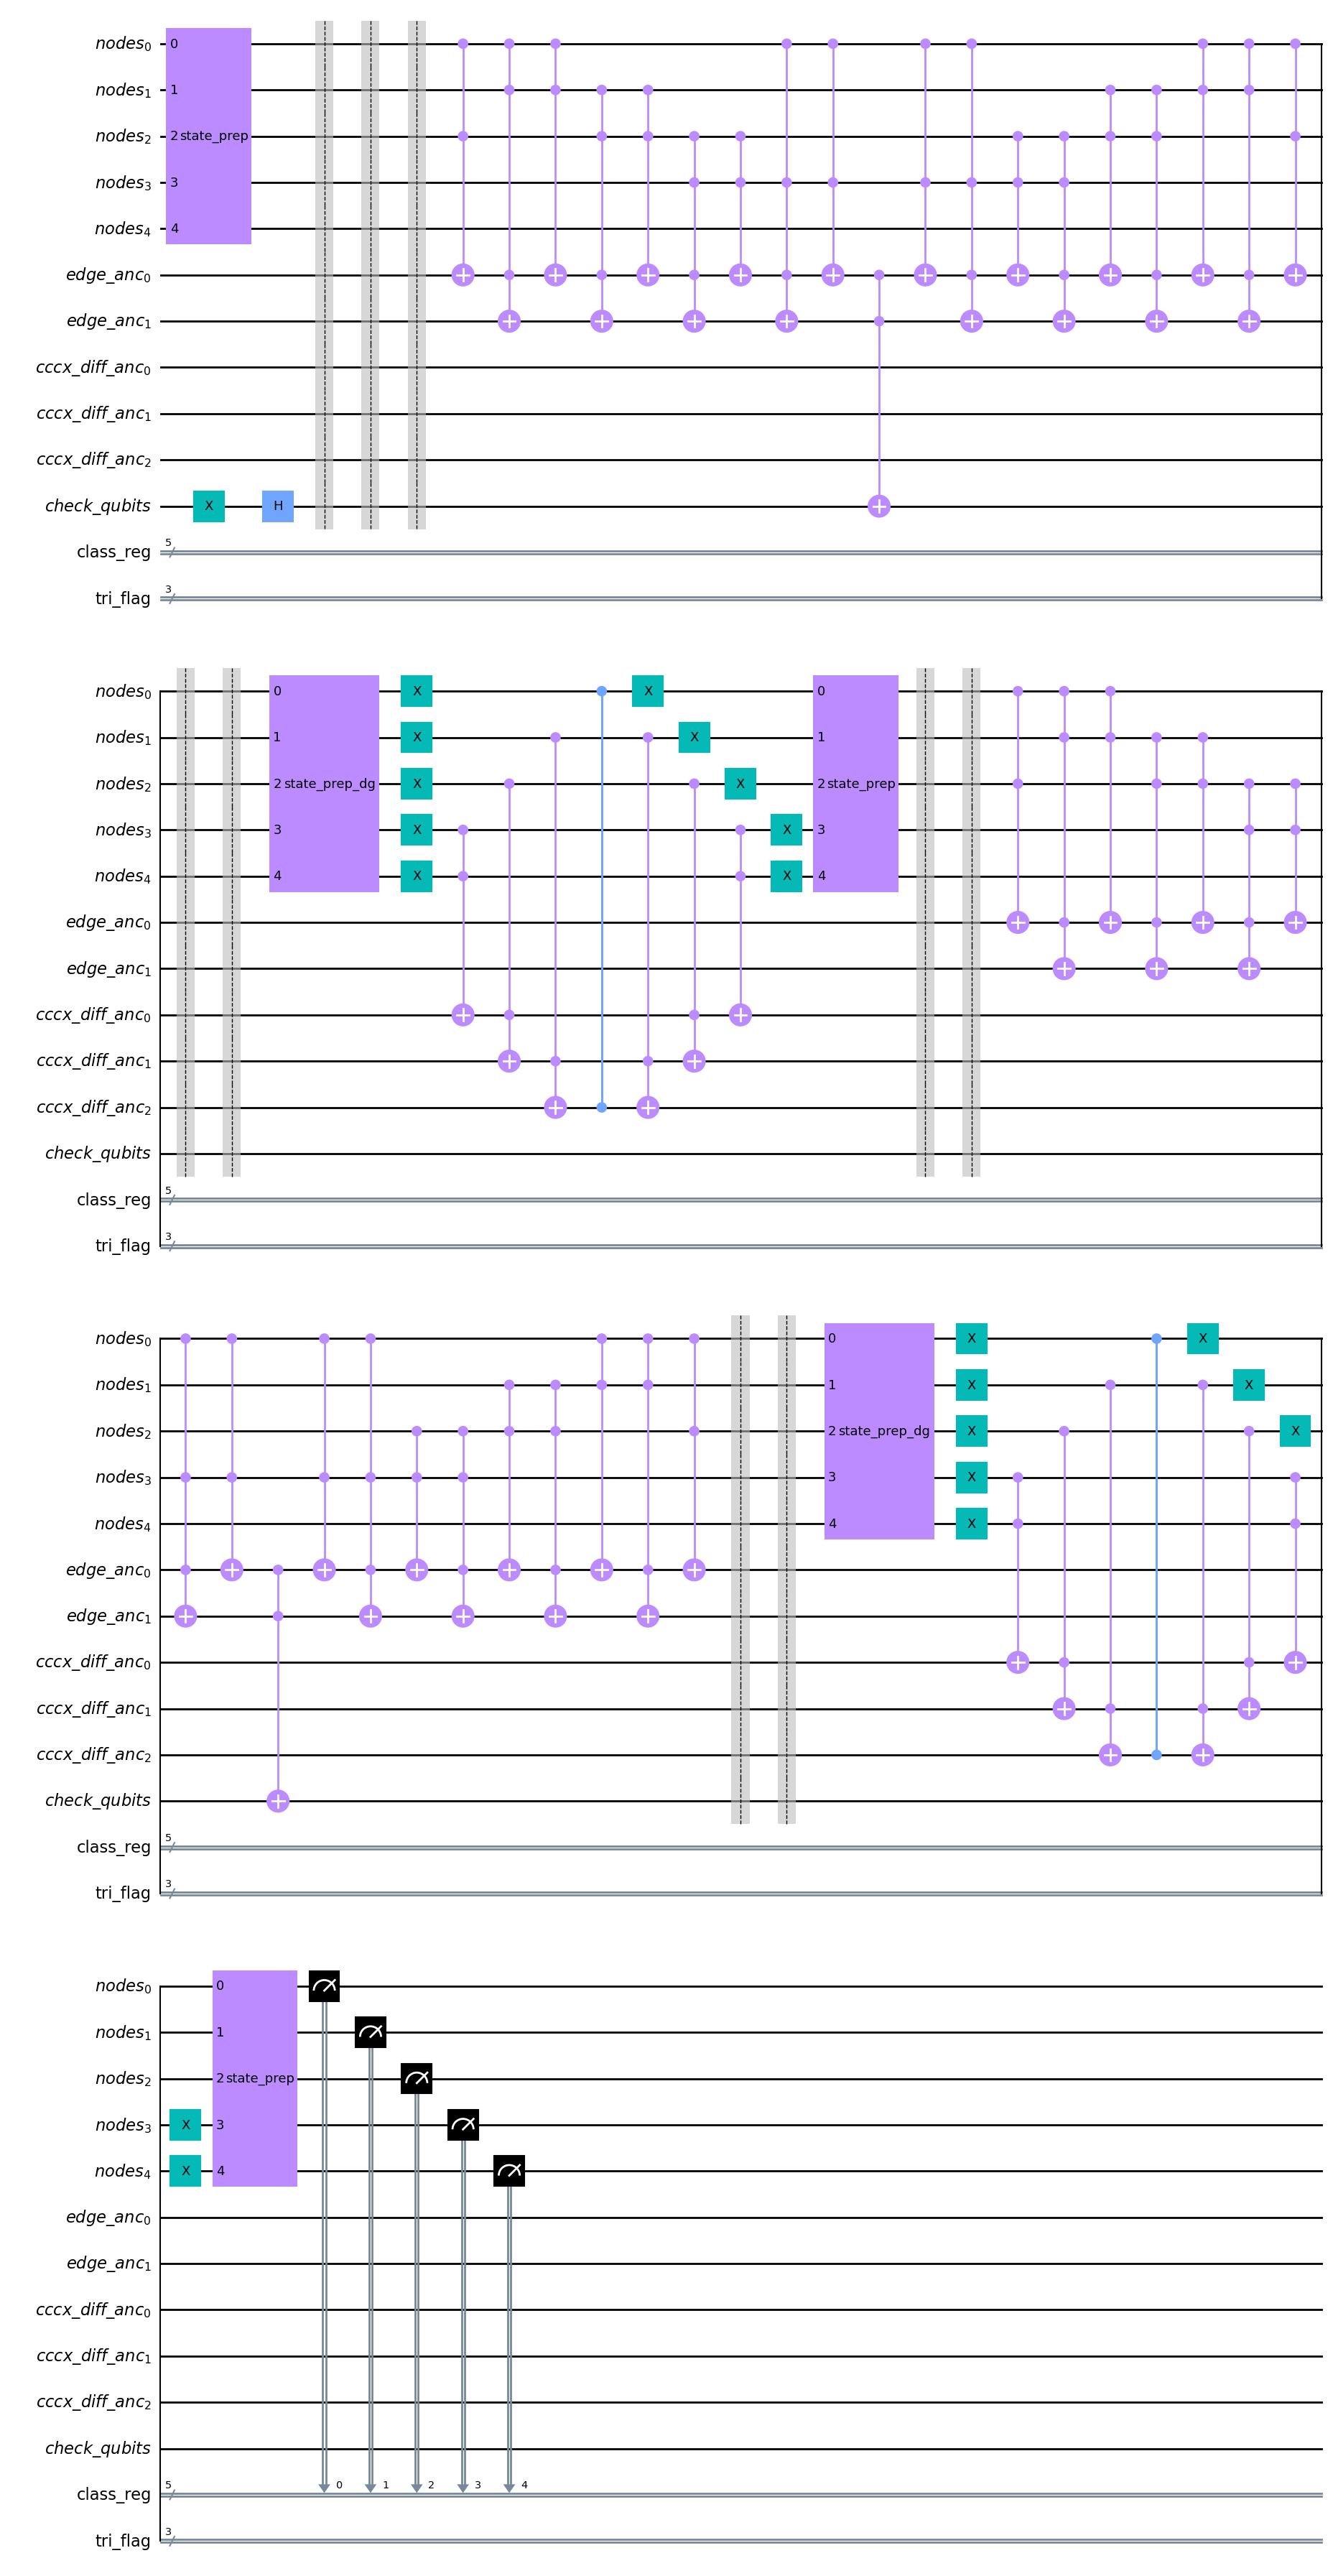

In [22]:
qc = grover_triangle_finder(n_nodes, edges)
qc.draw('mpl')

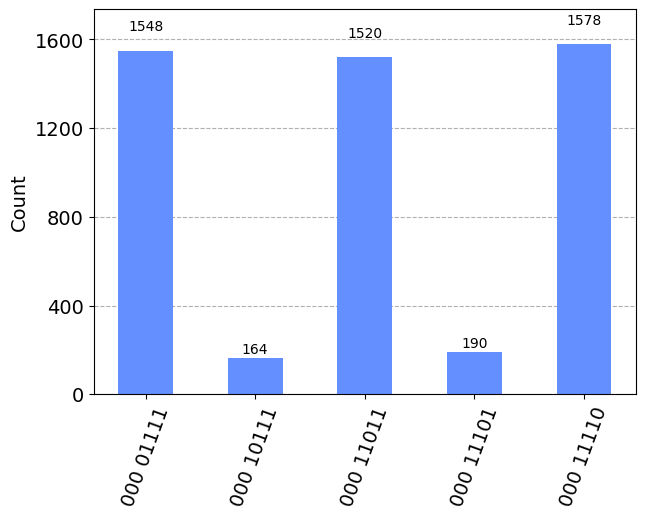

In [23]:
res = simulate(qc)
plot_histogram(res)

0111


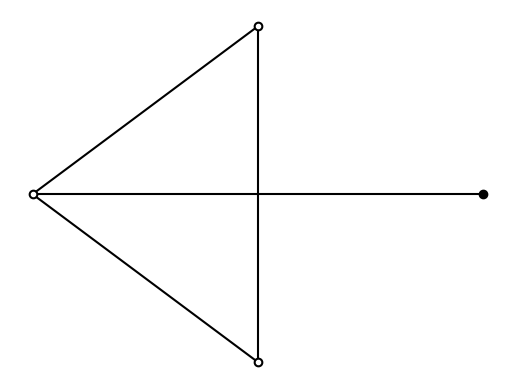

In [17]:
print(res.most_frequent()[::-1].split(" ")[0])
draw_graph(n_nodes, edges, found_str=res.most_frequent()[::-1].split(" ")[0])

After reversing the order of the bits, we see that those who participate in the triangle are marked with 1.

Let's try it with a different graph:

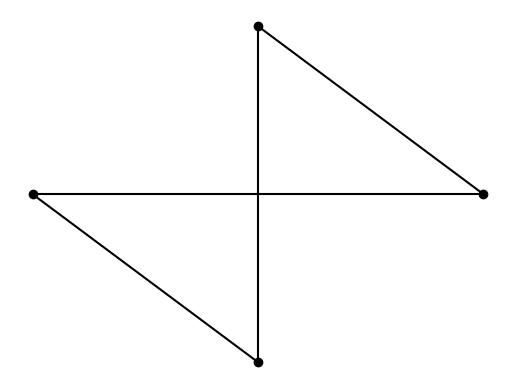

In [13]:
n_nodes = 4
edges =[(0, 1), (0, 2), (1, 3), (2, 3)]

draw_graph(n_nodes, edges)

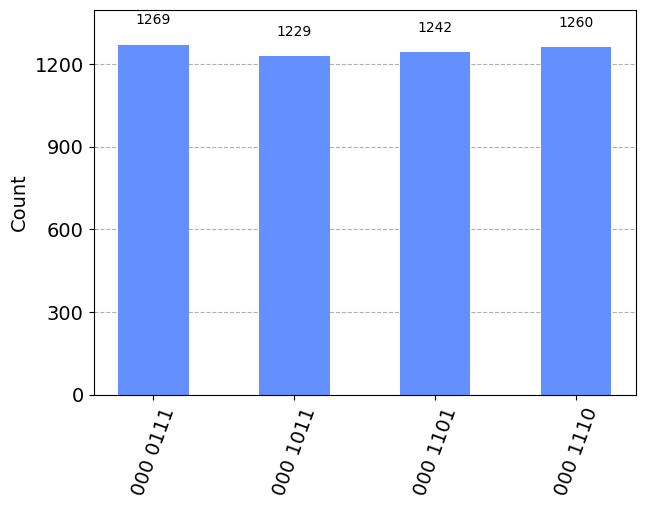

In [14]:
res = simulate(grover_triangle_finder(n_nodes, edges))
plot_histogram(res)

Here it can't find a triangle.

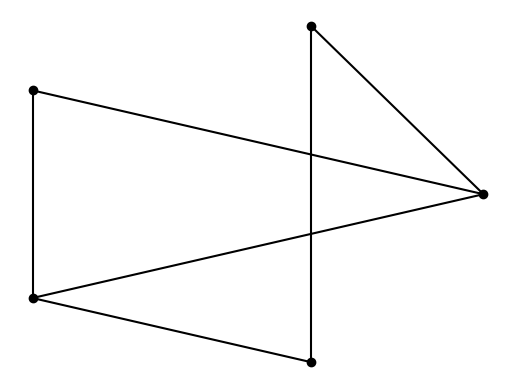

In [15]:
n_nodes = 5
edges =[(0, 1), (0, 2), (0, 3), (2, 3), (1, 4), (3, 4)]

draw_graph(n_nodes, edges)

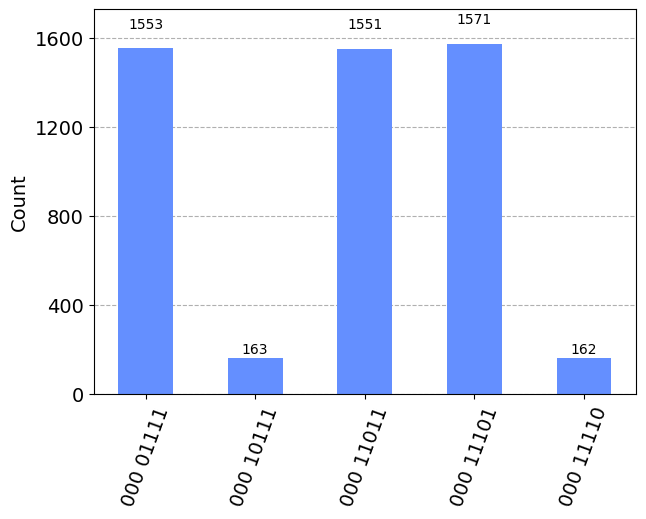

In [16]:
res = simulate(grover_triangle_finder(n_nodes, edges))
plot_histogram(res)

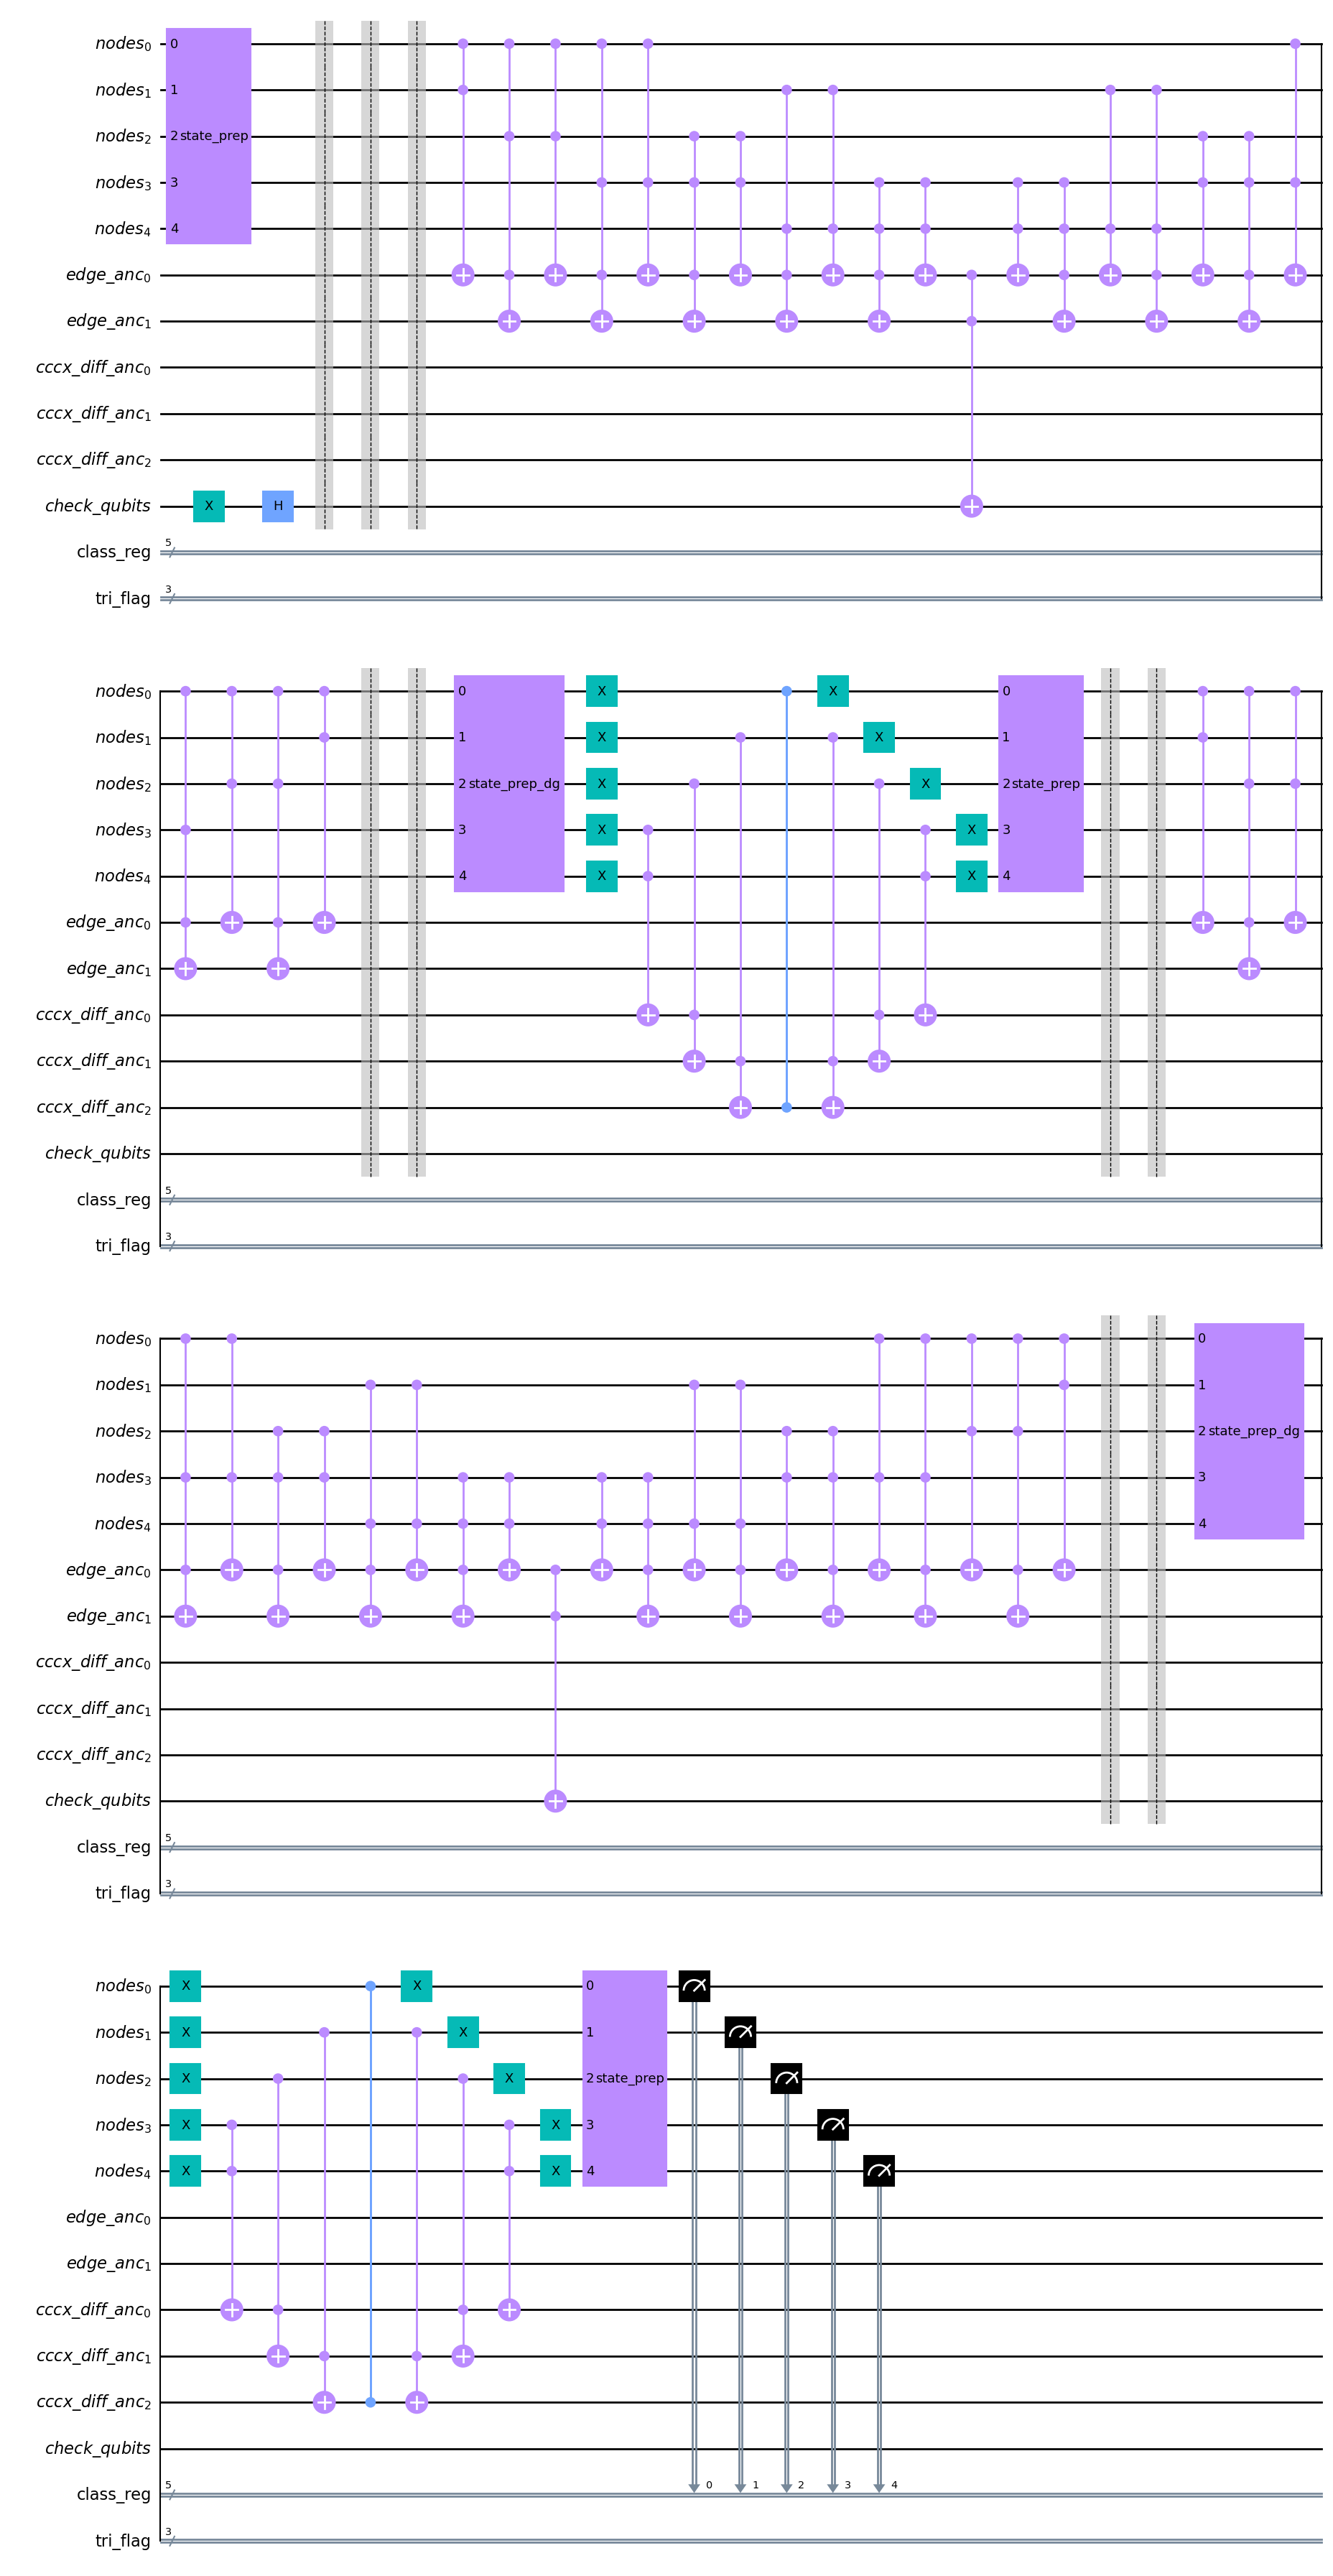

In [17]:
grover_triangle_finder(n_nodes, edges).draw("mpl")

The algorithm does not seem to work properly for higher numbers of nodes, even though the 0-2-3 triangle should've been detected as "000 01101".

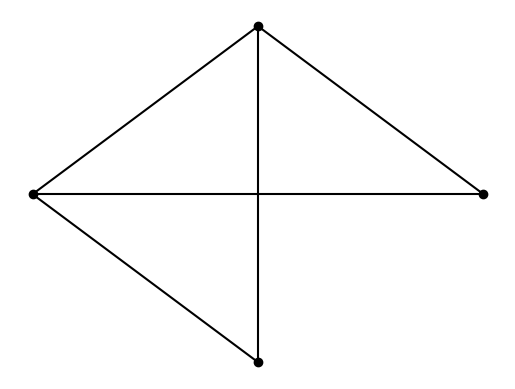

In [18]:
n_nodes = 4
edges =[(0, 1), (0, 2), (1, 3), (2, 3), (1, 2)]

draw_graph(n_nodes, edges)

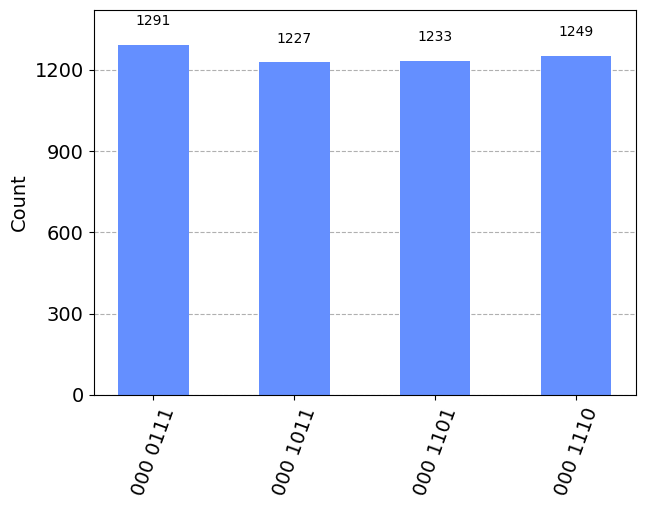

In [19]:
res = simulate(grover_triangle_finder(n_nodes, edges))
plot_histogram(res)

The algorithm also fails when there are 2 triangles available.

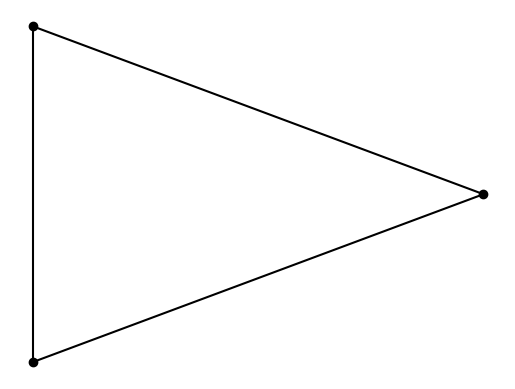

In [20]:
n_nodes = 3
edges =[(0, 1), (0, 2), (1, 2)]

draw_graph(n_nodes, edges)

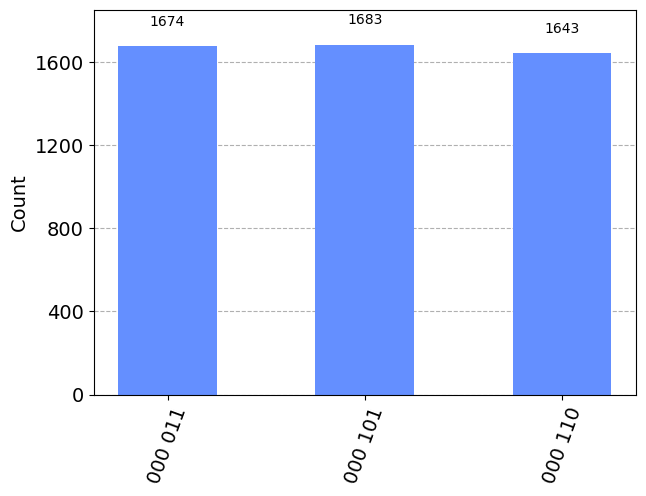

In [21]:
qc = grover_triangle_finder(n_nodes, edges)
res = simulate(qc)
plot_histogram(res)

Also does not work for a 3 node trivial graph. Results seem to always be "1 node off" rather than "3 nodes on".

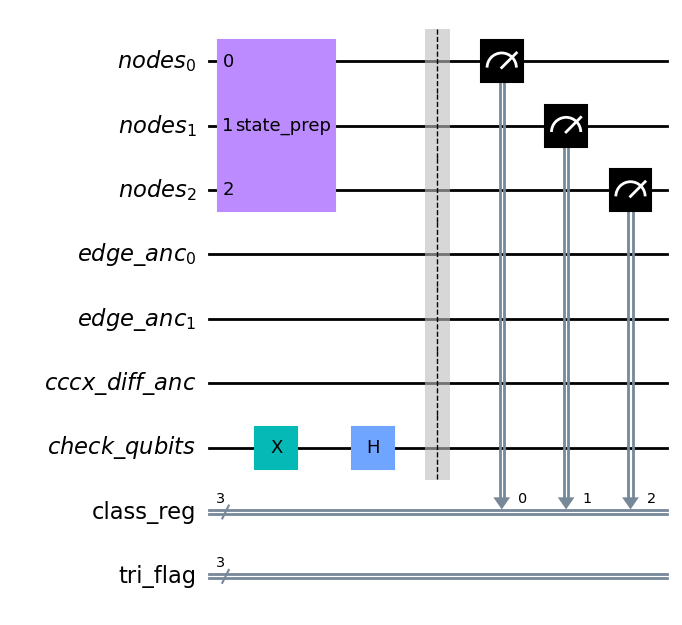

In [22]:
qc.draw("mpl")

...because for 3 nodes there is no Grover circuit at all.

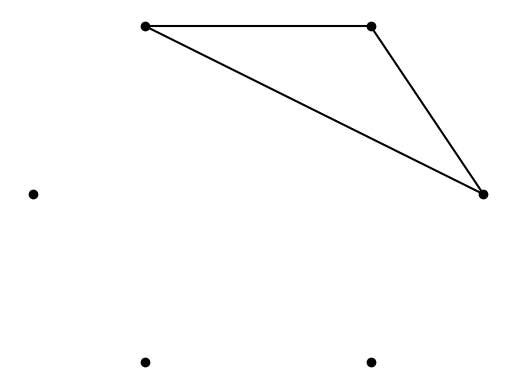

In [23]:
n_nodes = 6
edges =[(0, 1), (0, 2), (1, 2)]

draw_graph(n_nodes, edges)

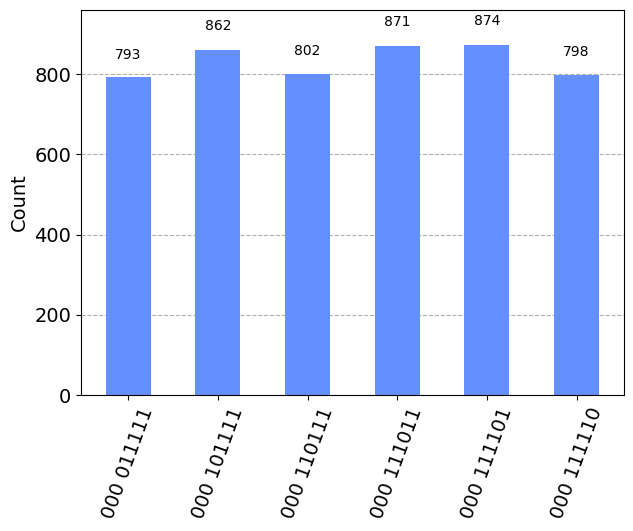

In [24]:
qc = grover_triangle_finder(n_nodes, edges)
res = simulate(qc)
plot_histogram(res)

Once again, there is one obvious triangle, but the algorithm only detects "all except one" states... weird.

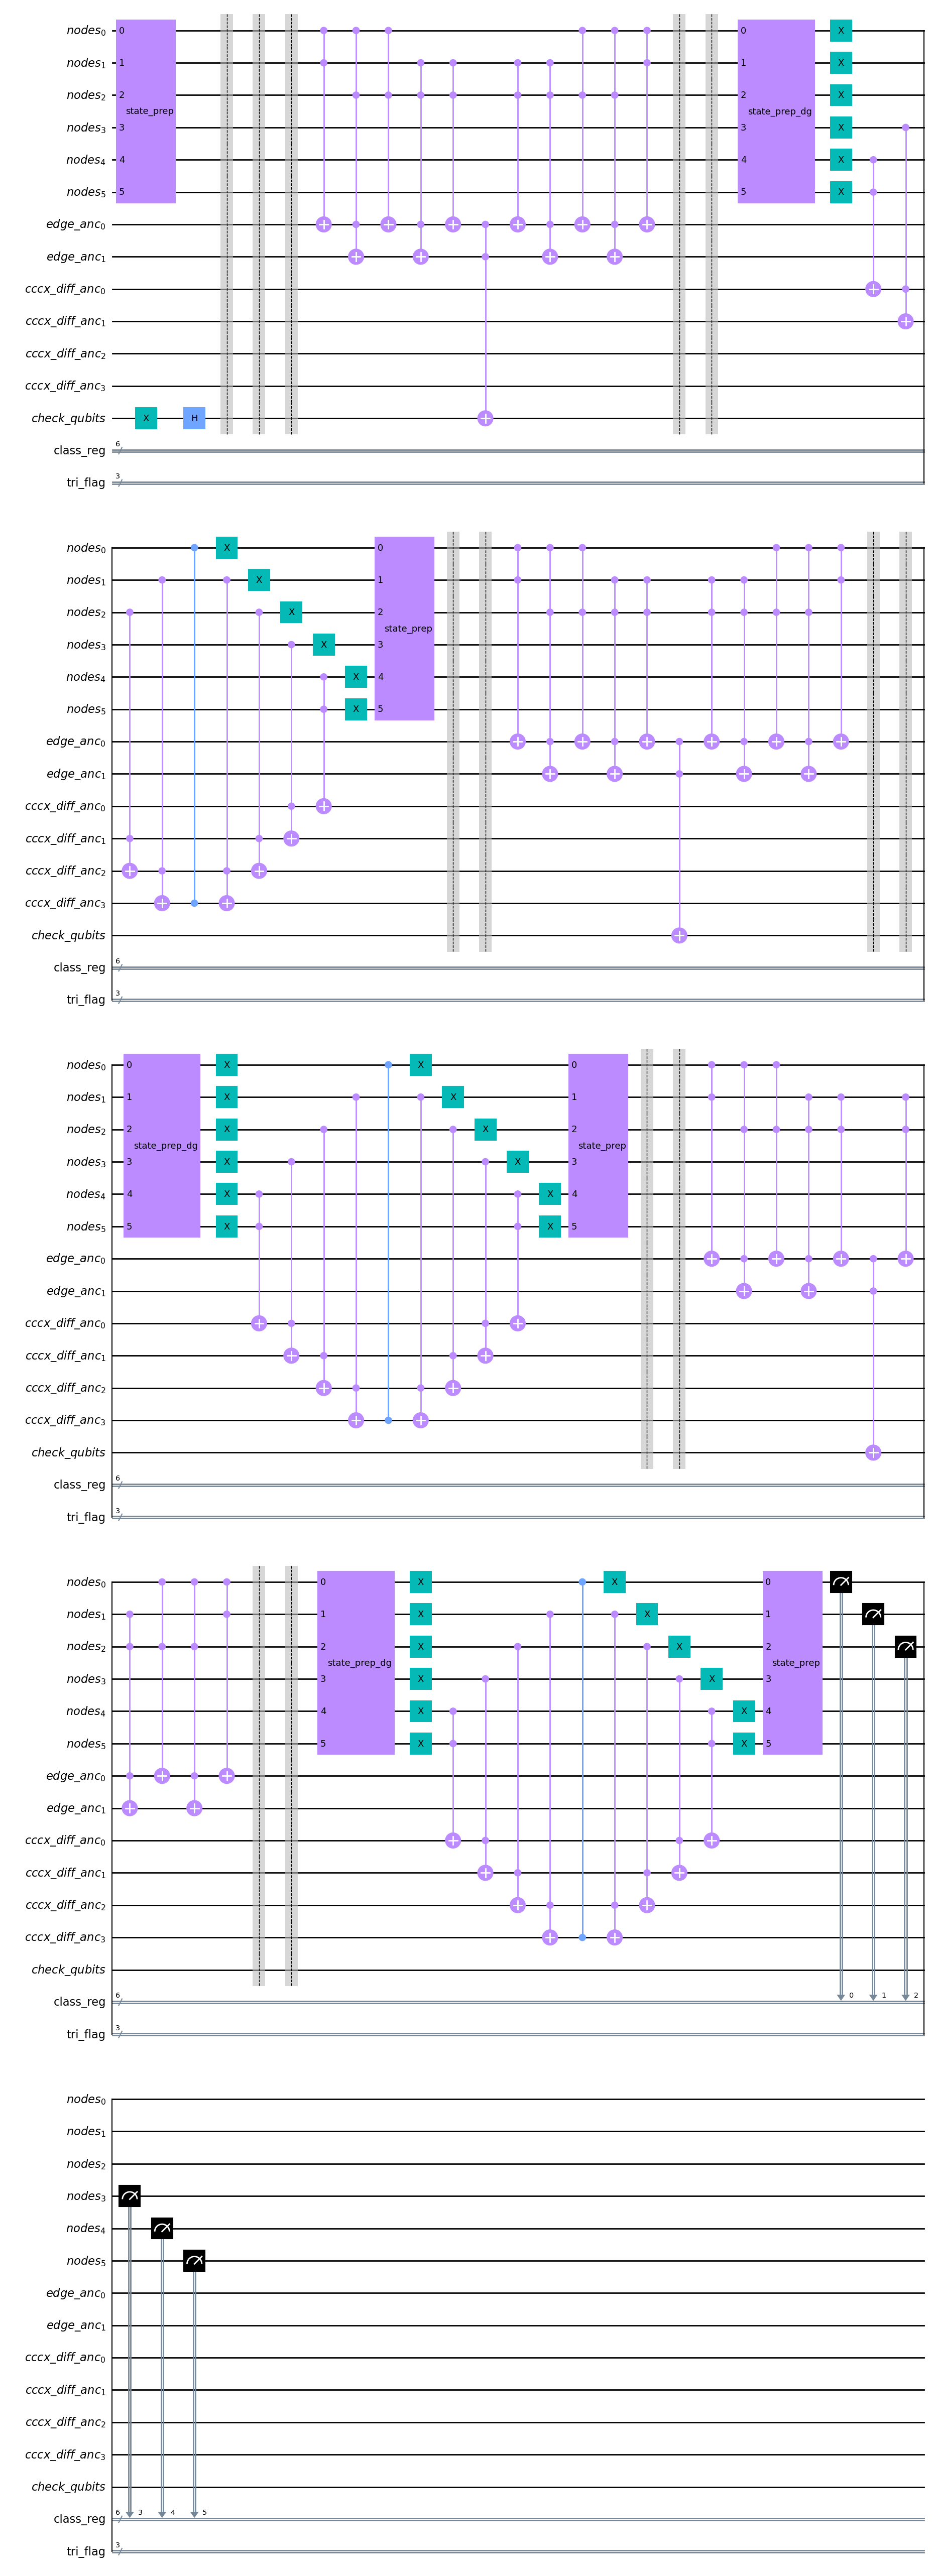

In [25]:
qc.draw("mpl")